<a href="https://colab.research.google.com/github/tg-bomze/collection-of-notebooks/blob/master/NeuralCorrector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font color="black" size="+4">NeuralCorrector v.1.0</font></b>

![visitors](https://visitor-badge.glitch.me/badge?page_id=mlart.NeuralCorrector&left_color=black&right_color=orange)

<b><font color="black" size="+2">Based on:</font></b>

**GitHub repository**: [glide-text2im](https://github.com/openai/glide-text2im), [latent-diffusion](https://github.com/CompVis/latent-diffusion)

Creator: **[openai](https://github.com/openai), [CompVis](https://github.com/CompVis)**

<b><font color="black" size="+2">Colab created by:</font></b>

GitHub: [@tg-bomze](https://github.com/tg-bomze),
Telegram: [@MLArt](https://t.me/MLArt),
Twitter: [@tg_bomze](https://twitter.com/tg_bomze).

```
(ENG) To get started, click on the button (where the red arrow indicates). After clicking, wait until the execution is complete.
```
```
(RUS) Чтобы начать, поочередно нажимайте на кнопки (куда указывают красные стрелки), дожидаясь завершения выполнения каждого блока.
```

In [1]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Install all necessary libraries</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Установить все необходимые библиотеки</font></b>

try: 
  !pip3 install googletrans==3.1.0a0
  from googletrans import Translator, constants
  from pprint import pprint
  translator = Translator()
except: pass

!git clone https://github.com/openai/glide-text2im
!pip install git+https://github.com/openai/glide-text2im
!pip install wget --quiet

%cd /content/glide-text2im
!git submodule update --init --recursive
!python setup.py install

from typing import Tuple
from IPython.display import display
from google.colab import files
from IPython.display import clear_output
import urllib.request
import PIL
import PIL.ImageOps
from PIL import Image
from tqdm import tqdm
import numpy as np
import torch as th
import torch.nn.functional as F

import base64, os, cv2, glob, wget
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
from shutil import copyfile
import shutil

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler)

canvas_html = """
<style>
.button {
  background-color: #4CAF50;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>

<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

def denoised_fn(x_start):
    # Force the model to have the exact right x_start predictions
    # for the part of the image which is known.
    return (
        x_start * (1 - model_kwargs['inpaint_mask'])
        + model_kwargs['inpaint_image'] * model_kwargs['inpaint_mask'])

def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(PIL.Image.fromarray(reshaped.numpy()))

def read_image(path: str, size: int = 256) -> Tuple[th.Tensor, th.Tensor]:
    pil_img = PIL.Image.open(path).convert('RGB')
    pil_img = pil_img.resize((size, size), resample=PIL.Image.BICUBIC)
    img = np.array(pil_img)
    return th.from_numpy(img)[None].permute(0, 3, 1, 2).float() / 127.5 - 1

def read_mask(path: str, size: int = 256) -> Tuple[th.Tensor, th.Tensor]:
    pil_img = PIL.Image.open(path).convert('L')
    pil_img = PIL.ImageOps.invert(pil_img)
    pil_img = pil_img.resize((size, size), resample=PIL.Image.BICUBIC)
    img = np.array(pil_img)[..., np.newaxis]
    return th.from_numpy(img)[None].permute(0, 3, 1, 2).float() / 255.0

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

clear_output()

# Create base model.
print('Downloading 1/2 ...')
options = model_and_diffusion_defaults()
options['inpaint'] = True
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base-inpaint', device))

# Create upsampler model.
print('Downloading 2/2 ...')
options_up = model_and_diffusion_defaults_upsampler()
options_up['inpaint'] = True
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample-inpaint', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

clear_output()

'''%cd /content
!rm -rf /content/Real-ESRGAN
!git clone https://github.com/xinntao/Real-ESRGAN
%cd /content/Real-ESRGAN
!git checkout 4211085
!pip install -U basicsr
!pip install -U facexlib
!python setup.py develop
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P /content/Real-ESRGAN/experiments/pretrained_models

from basicsr.archs.rrdbnet_arch import RRDBNet
from realesrgan import RealESRGANer

model_sr = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
upsampler_sr = RealESRGANer(scale=4, model_path='/content/Real-ESRGAN/experiments/pretrained_models/RealESRGAN_x4plus.pth', model=model_sr, tile=0, tile_pad=10, pre_pad=0, half=False)
clear_output() # '''

%cd /content
!git clone https://github.com/CompVis/latent-diffusion.git
!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers
!pip install ipywidgets omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops

import sys
import torch
import IPython.display as d
sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan

%cd /content/latent-diffusion
import ipywidgets as widgets
from IPython.display import display
from notebook_helpers import get_model, get_custom_cond, get_cond_options, get_cond, run
mode_sr2 = widgets.Select(options=['superresolution'], value='superresolution', description='Task:')
model_sr2 = get_model(mode_sr2.value)
clear_output()

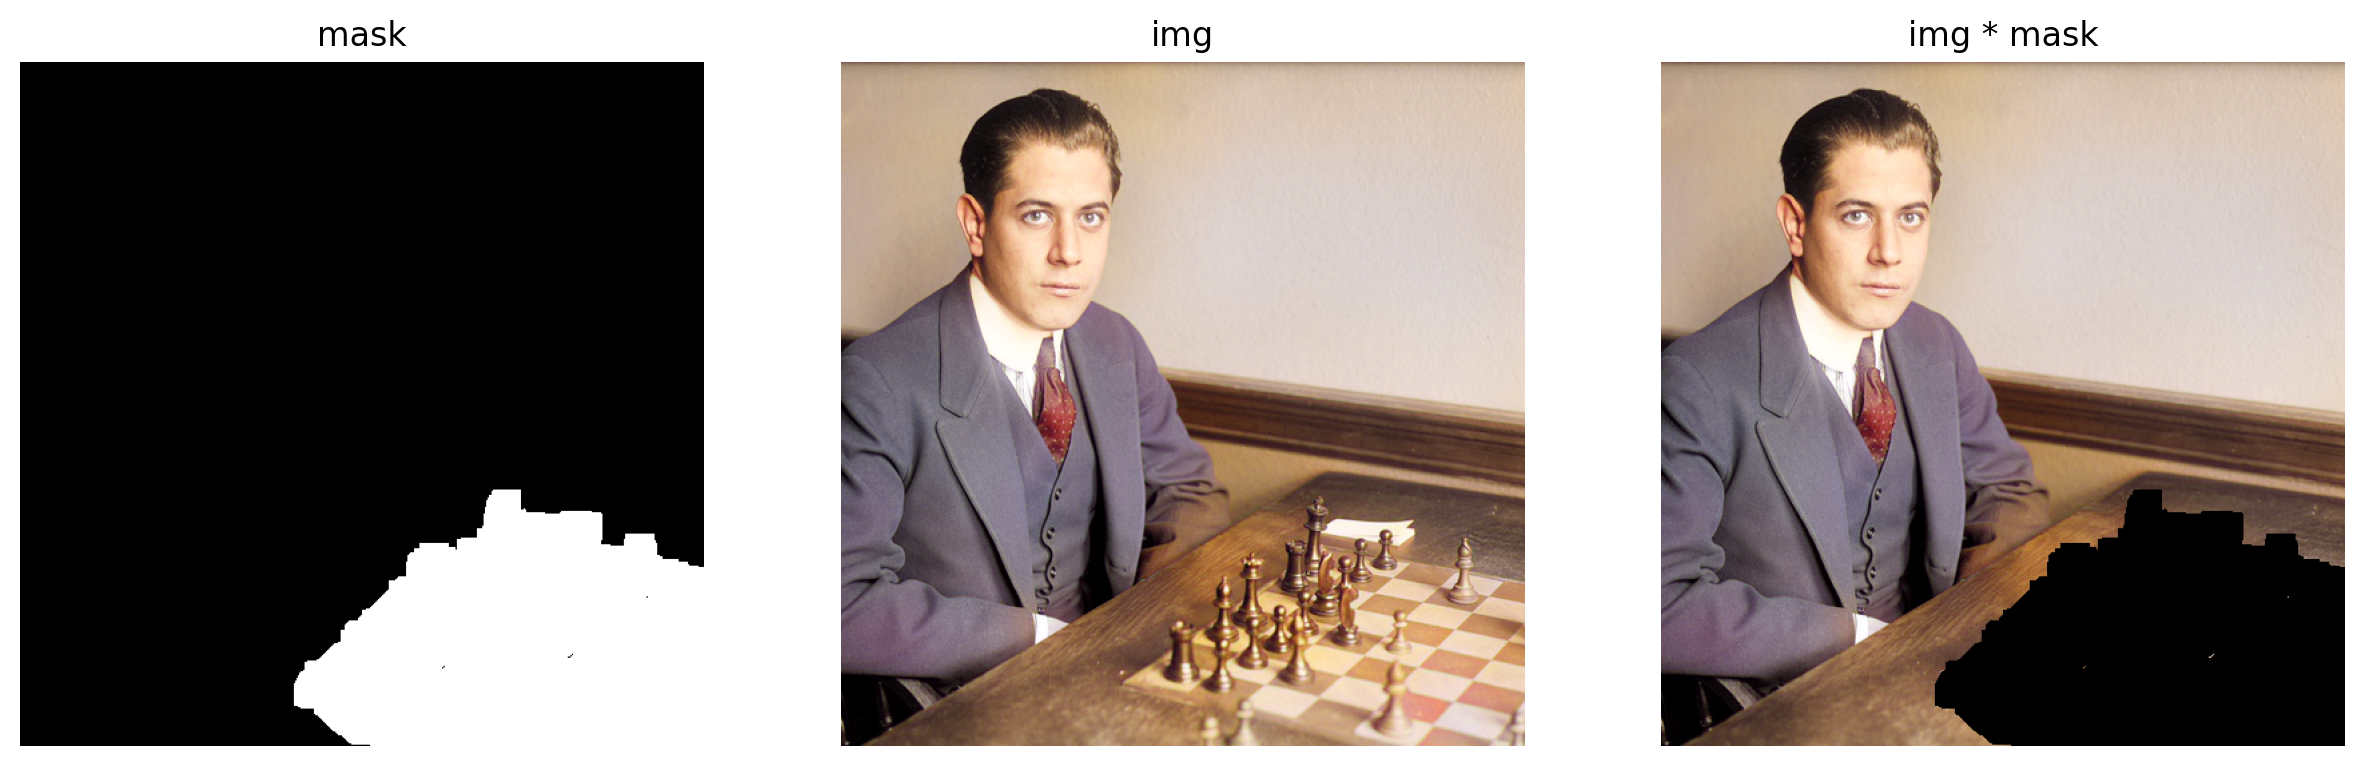

In [16]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Upload image</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Загрузить изображение</font></b>
%cd /content
#@markdown Leave **image_url** blank to upload an image from your computer.
image_url = "" #@param {type:"string"}

if image_url is "":
  f = files.upload()
  fname = list(f.keys())[0]
else:
  fname = wget.download(image_url)

# ----------------------------------------------------------------

shutil.rmtree('/content/data', ignore_errors=True)
!mkdir /content/data

img = PIL.Image.open(fname)
w, h = img.size
if w > h: im = img.crop((int((w-h)/2), 0, w-int((w-h)/2), h))
elif h > w: im = img.crop((0, int((h-w)/2), w, h-int((h-w)/2)))
else: im = img
img = im.resize((512,512), PIL.Image.ANTIALIAS)
fname = f"/content/data/image.png"
img.save(fname)

image64 = base64.b64encode(open(fname, 'rb').read())
image64 = image64.decode('utf-8')
img = np.array(plt.imread(f'{fname}')[:,:,:3])

mname = f"/content/data/mask.png"
print('---------------------------------------------------------')
print('(ENG) Paint over the area to be edited and click "Finish"')
print('---------------------------------------------------------\n')

print('----------------------------------------------------------------')
print('(RUS) Закрасьте область, которую хотите отредактировать и нажмите "Finish"')
print('----------------------------------------------------------------\n')
draw(image64, filename=mname, w=img.shape[1], h=img.shape[0], line_width=0.04*img.shape[1])
with_mask = np.array(plt.imread(mname)[:,:,:3])
mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
clear_output()

plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['figure.dpi'] = 200

plt.subplot(131)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('mask')
plt.imsave(mname,mask, cmap='gray')

plt.subplot(132)
img = np.array(plt.imread(f'{fname}')[:,:,:3])
plt.imshow(img)
plt.axis('off')
plt.title('img')

plt.subplot(133)
img = np.array((1-mask.reshape(mask.shape[0], mask.shape[1], -1))*plt.imread(fname)[:,:,:3])
_=plt.imshow(img)
_=plt.axis('off')
_=plt.title('img * mask')
plt.show()

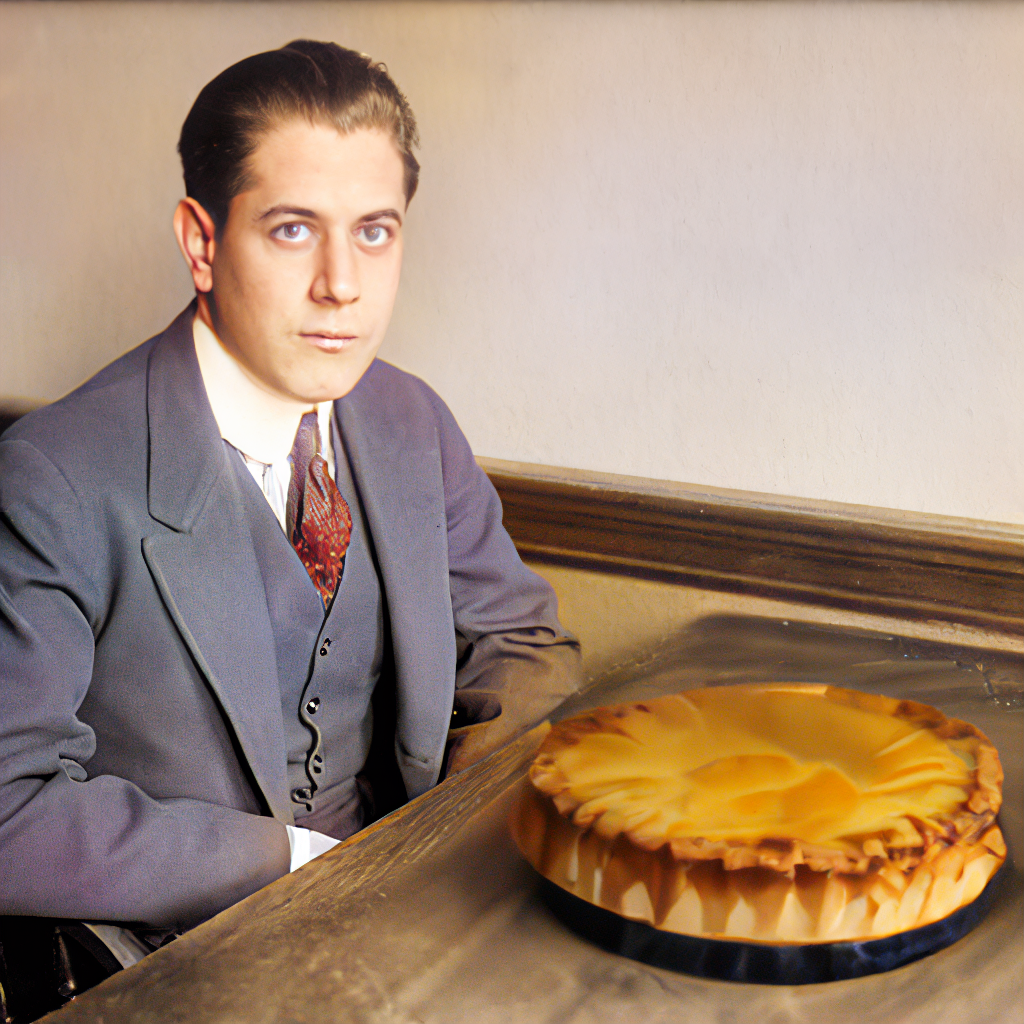

In [24]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Run</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Запуск</font></b>

text = "\u043C\u0443\u0436\u0447\u0438\u043D\u0430 \u0438 \u043F\u0438\u0440\u043E\u0433 \u043D\u0430 \u0441\u0442\u043E\u043B\u0435" #@param {type:"string"}
try:
  translator = Translator()
  translation = translator.translate(text)
  prompt = translation.text
except: prompt = text

batch_size = 1
guidance_scale = 5.0
upsample_temp = 0.997 

im_mask = cv2.imread(mname)
im_mask = cv2.cvtColor(im_mask,cv2.COLOR_BGR2GRAY)
contours, hierarchy = cv2.findContours(im_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(im_mask, contours, -1, (255,255,255), 5)
cv2.imwrite(mname, im_mask)

source_image_64 = read_image('/content/data/image.png', size=64)
source_mask_64 = read_mask('/content/data/mask.png', size=64)
source_mask_64 = (source_mask_64>0.5).float()
print("Generation 1/2 ...")

# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),

    # Masked inpainting image
    inpaint_image=(source_image_64 * source_mask_64).repeat(full_batch_size, 1, 1, 1).to(device),
    inpaint_mask=source_mask_64.repeat(full_batch_size, 1, 1, 1).to(device),
)

# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
    denoised_fn=denoised_fn,
)[:batch_size]
model.del_cache()

# ------------------------------------------------------------------

source_image_256 = read_image('/content/data/image.png', size=256)
source_mask_256 = read_mask('/content/data/mask.png', size=256)
source_mask_256 = (source_mask_256>0.5).float()
print("Generation 2/2 ...")

tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),

    # Masked inpainting image.
    inpaint_image=(source_image_256 * source_mask_256).repeat(batch_size, 1, 1, 1).to(device),
    inpaint_mask=source_mask_256.repeat(batch_size, 1, 1, 1).to(device),
)

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.p_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
    denoised_fn=denoised_fn,
)[:batch_size]
model_up.del_cache()

scaled = ((up_samples + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
img = scaled.permute(2, 0, 3, 1).reshape([up_samples.shape[2], -1, 3]).numpy()

'''clear_output()
output, _ = upsampler_sr.enhance(img, outscale=4)
output_to_save = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
cv2.imwrite('/content/result.png', output_to_save)
display(PIL.Image.fromarray(output)) #'''

output_to_sr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
!rm -rf /content/latent-diffusion/data/example_conditioning/superresolution/*
cond_choice_path = '/content/latent-diffusion/data/example_conditioning/superresolution/result.png'
cv2.imwrite(cond_choice_path, output_to_sr)
cond_choice = widgets.RadioButtons(options=options, description='Select conditioning:', disabled=False)
custom_steps = 100
logs = run(model_sr2["model"], cond_choice_path, mode_sr2.value, custom_steps)
clear_output()
sample = logs["sample"]
sample = sample.detach().cpu()
sample = torch.clamp(sample, -1., 1.)
sample = (sample + 1.) / 2. * 255
sample = sample.numpy().astype(np.uint8)
sample = np.transpose(sample, (0, 2, 3, 1))
a = PIL.Image.fromarray(sample[0])
display(a)